<a href="https://www.kaggle.com/code/mcpenguin/precious-metals-stocks-eda-and-prediction?scriptVersionId=143235063" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

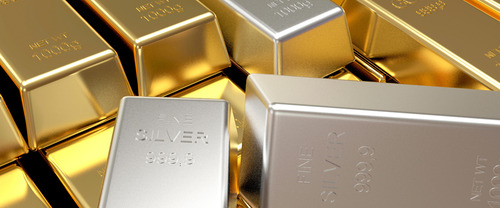

# Precious Metals Stocks - EDA and Prediction

In this notebook, we investigate the stock data of five precious metals: Gold, Silver, Copper, Platinum and Palladium. 

We will perform some initial EDA, and use feature engineering to make the variate stationary. Then, we will use a LSTM model to predict future stock prices for each of the five metals.

## References

I used these notebooks as references for this notebook. Please go upvote them and give kudos to the authors.

- https://www.kaggle.com/code/jillanisofttech/amazon-stock-price-predication-using-lstm-and-rnn/notebook

## Some of my other work

### Notebooks

- [Butterfly Image Classification](https://www.kaggle.com/code/mcpenguin/butterfly-classification-efficientnet-87)
- [Palmer Penguin EDA](https://www.kaggle.com/code/mcpenguin/palmer-archipelago-antarctica-penguin-eda)
- [Smoking and Drinking EDA + Classification](https://www.kaggle.com/code/mcpenguin/smoking-drinking-prediction-tfdf-71)
- [World Happiness Data Cleaning + EDA](https://www.kaggle.com/code/mcpenguin/world-happiness-data-cleaning-eda)
- [Red Wine Quality EDA + Prediction](https://www.kaggle.com/code/mcpenguin/red-wine-quality-prediction)
- [Gaia Stellar Classification](https://www.kaggle.com/code/mcpenguin/gaia-stellar-classification-lightgbm-91-acc)

### Datasets

- [Malaysian Condominium Prices Data](https://www.kaggle.com/datasets/mcpenguin/raw-malaysian-housing-prices-data)
- [The Complete Rollercoasters Dataset](https://www.kaggle.com/datasets/mcpenguin/rollercoasters)
- [Malaysian COVID-19 Data](https://www.kaggle.com/datasets/mcpenguin/malaysia-covid19)
- [Super Mario 64 Speedruns](https://www.kaggle.com/datasets/mcpenguin/super-mario-64-speedruns)

# Import Libraries Needed

In [ ]:
import numpy as np
import pandas as pd
import os
from itertools import product
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.stattools import kpss

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

import tensorflow as tf

In [ ]:
pd.set_option('display.max_columns', None)

# Load Data

In [ ]:
df = pd.read_csv("/kaggle/input/precious-metals-data/all_commodities_data.csv")
df.head()

Let's get information about this dataset by using the `info()` command:

In [ ]:
df.info()

From this, we see that the data has no missing values. We should convert the `date` variate in our dataset to be a `datetime` type.

In [ ]:
df["date"] = df["date"].astype('datetime64')
df.info()

We can also use the `describe()` command to try to get information about the nature of the variates:

In [ ]:
df.describe()

Let's also try to understand the unique values in the categorical variates:

In [ ]:
for col in ["ticker", "commodity"]:
    print(f"Unique values for {col}: {df[col].unique()}")

We see that there is a direct 1-1 correspondence between the ticker and commodity name, which should be expected.

# Exploratory Data Analysis

## Stock Open/Close Prices

We can first investigate the trend of the stock open and close prices over time.

In [ ]:
ax = sns.lineplot(data=df, x="date", y="open", hue="commodity")
ax.set_yscale('symlog')
ax.set(title="Open Prices")
plt.show()

In [ ]:
ax = sns.lineplot(data=df, x="date", y="close", hue="commodity")
ax.set_yscale('symlog')
ax.set(title="Close Prices")
plt.show()

Observations:

* With the exception of Gold, the open/close prices for all the stocks have dips in their stock prices around the year 2008. We can speculate this is due to the 2008 financial crisis that occurred around that time.

## Stock Volume

We can also investigate the trends of the stock volumes using a similar analysis.

In [ ]:
ax = sns.lineplot(data=df, x="date", y="volume", hue="commodity")
ax.set_yscale('symlog')
ax.set(title="Volume")
plt.show()

We see that there is a lot of variability in the data. So, instead, something we could do is plot the moving average of the data.

In [ ]:
df["timestamp"] = df["date"].apply(lambda d: d.timestamp())

ax = sns.lineplot(data=df.groupby("commodity").rolling(200).mean(), x="timestamp", y="volume", hue="commodity")
ax.set_yscale('symlog')
ax.set(title="Volume")
plt.show()

## ACF

When dealing with time series data, it might be helpful to investigate the auto-correlation function (acf) plots of the data to investigate any trends/seasonality in the data.

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,30))
cols = ['open', 'high', 'low', 'close']

for ax, (commodity, col) in zip(axes.flat, product(df['commodity'].unique(), cols)):
    plot_acf(x=df.loc[df["commodity"] == commodity, col], ax=ax, lags=1000)
    ax.set(title=f"ACF of {col} for {commodity}")
    
plt.show()

From the ACF plots, we see that

* There are no clear trends or seasonality in the stock prices; and

* Later stock prices have less similarity with the current stock price.

## Scatterplots of Stock Prices between Differing Commodities

We can also investigate whether there are any correlations between the stock prices between differing commodities.

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))

for ax, (c1, c2) in zip(axes.flat, product(df['commodity'].unique(), df['commodity'].unique())):
    df1 = df.loc[df['commodity'] == c1]
    df2 = df.loc[df['commodity'] == c2]
    df_merged = df1.merge(df2, on="date", suffixes=('1', '2'))
    corr_coeff = df_merged.corr(numeric_only=True)['open1']['open2']
    
    sns.scatterplot(data=df_merged, x="open1", y="open2", ax=ax)
    ax.set_xlabel(f"{c1} open price")
    ax.set_ylabel(f"{c2} open price")
    ax.set_title(fr"{c1} vs {c2} [$\rho = {round(corr_coeff, 4)}$]")
    
plt.show()

From this, we see that there are some significant correlations between the stock prices of the different commodities.

## Correlation Matrix

We can also investigate the correlation matrix between the different variates as well.

In [ ]:
sns.heatmap(df.corr(numeric_only=True))
plt.show()

We see that there are no correlations between `volume` and the other variates, whilst the other four variates have near perfect correlations with each other. In particular, this entails that we should be able to carry over most inferences made on the value of `open` to `high`, `low` and `close`.

## Percentage Change in Stock Price

Another variate that could be useful to investigate might be the percentage change in the (open) stock price.

In [ ]:
df['pct_change'] = df.groupby('commodity', group_keys=False)['open'].apply(pd.Series.pct_change)

We can investigate the trends of the percentage change over time:

In [ ]:
ax = sns.lineplot(data=df, x="date", y="pct_change", hue="commodity")
ax.set(title="% Change in Open Stock Price")
plt.show()

We see that there are two distinct spikes in this graph:

* one at 2008, which roughly corresponds to the 2008 financial crisis; and

* one at 2020, which roughly corresponds to the start of the COVID-19 pandemic.

## Stationary Test

*Thank you to [@kkhandekar](https://www.kaggle.com/kkhandekar) for the suggestion.*

When dealing with time series data, a test we could do would be an Augmented Dickey-Fuller test, which will test whether the stock prices are stationary. If they are, converting the data to be non-stationary can help our model performance later on.

In [ ]:
commodities = ["Gold", "Silver", "Copper", "Platinum", "Palladium"]

def perform_kpss_test(data):
    result = kpss(data)
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Lags Used: %f' % result[2])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))

for comm in commodities:
    print(f"Performing KPSS test for {comm}")
    data = df.loc[df["commodity"] == comm, "open"]
    perform_kpss_test(data)
    print()

We observe that the p-values of all the tests are smaller than 0.05, which signifies that the time series data have unit roots, and so are non-stationary.

# Feature Engineering

Our goal will be to predict the (open) stock prices of the different commodities in 2023 using the previous stock data. To do this, we will need to add some features to our dataset before passing it into modelling:

* We should add extra features that incorporate more information about the `date` variate; for example, the day, week, month, day of week, etc.

* We should add columns for the open, close, low and high prices for each commodity in our dataset.

## Adding Datetime Specific Features

In [ ]:
# add datetime specific features
df["timestamp"] = df["date"].apply(lambda d: d.timestamp())
df["day"] = df["date"].dt.day
df["week"] = df["date"].dt.isocalendar().week
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df["day_of_week"] = df["date"].dt.dayofweek

df.sample(5)

## Making Data Stationary

In our EDA, we found that the stock (open) prices for each commodity are non-stationary. As such, to improve modelling, we should make them stationary.

To do this, we will do 

1. a log transformation to the open stock prices; and

2. compute the differences between the log open stock prices.

In [ ]:
df["log_open"] = np.log(df["open"])
for comm in commodities:
    data = df.loc[df["commodity"] == comm, "log_open"]
    df.loc[df["commodity"] == comm, "diff_log_open"] = data.diff()
    # set diff of first element to be 0, since it is currently NA
    df.loc[(df["commodity"] == comm).idxmax(), "diff_log_open"] = 0

df.head()

We can check whether this new variate `diff_log_open` is stationary:

In [ ]:
for comm in commodities:
    print(f"Performing KPSS test for (diff_log) {comm}")
    data = df.loc[df["commodity"] == comm, "diff_log_open"]
    perform_kpss_test(data)
    print()

As we can see, the p-values are now more than 0.1, which suggests this transformed variate is now stationary.

## Training, Validation, Test Split

We can next initialize the data frames we will be using for training, validation and testing purposes. We will focus on predicting the open stock prices for each of the precious metals.

TODO: need to apply "rolling window" (see example in amazon notebook)

In [ ]:
response_base = "diff_log_open"

TRAINING_CUTOFF = dt.datetime(2016, 12, 31)
VALIDATION_CUTOFF = dt.datetime(2021, 12, 31)
TEST_CUTOFF = df["date"].max()

def make_df(daterange):
    new_df = pd.DataFrame({"date": daterange})
    new_df["timestamp"] = new_df["date"].apply(lambda d: d.timestamp())
    new_df["day"] = new_df["date"].dt.day
    new_df["week"] = new_df["date"].dt.isocalendar().week
    new_df["month"] = new_df["date"].dt.month
    new_df["year"] = new_df["date"].dt.year
    new_df["day_of_week"] = new_df["date"].dt.dayofweek
    
    cols = ["date", "open", "log_open", response_base]
    for comm in commodities:
        new_df = new_df.merge(df[df["commodity"] == comm][cols], on="date", suffixes=(None, f"_{comm}"))
    # first column doesn't get suffix, so we do this manually
    new_df.rename(columns={"open": "open_Gold"}, inplace=True)
    new_df.rename(columns={"log_open": "log_open_Gold"}, inplace=True)
    new_df.rename(columns={response_base: f"{response_base}_Gold"}, inplace=True)
    new_df.drop(columns=["date"], inplace=True)
    return new_df
               
training_daterange = pd.date_range(df["date"].min(), TRAINING_CUTOFF)
validation_daterange = pd.date_range(TRAINING_CUTOFF + dt.timedelta(days=1), VALIDATION_CUTOFF)
test_daterange = pd.date_range(VALIDATION_CUTOFF + dt.timedelta(days=1), TEST_CUTOFF)

training_df = make_df(training_daterange)
validation_df = make_df(validation_daterange)
test_df = make_df(test_daterange)

training_df.sample(5)

We can then split these up into the corresponding explanatory and response variates.

In [ ]:
drop_cols = ["open", response_base]

X_train = training_df.drop(columns=map(lambda x: f"{x[0]}_{x[1]}", product(drop_cols, commodities)))
X_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1)).astype('float32')
y_train = {comm: training_df[f"{response_base}_{comm}"].values.astype('float32') for comm in commodities}

X_val = validation_df.drop(columns=map(lambda x: f"{x[0]}_{x[1]}", product(drop_cols, commodities)))
X_val = np.reshape(X_val.values, (X_val.shape[0], X_val.shape[1], 1)).astype('float32')
y_val = {comm: validation_df[f"{response_base}_{comm}"].values.astype('float32') for comm in commodities}

X_test = test_df.drop(columns=map(lambda x: f"{x[0]}_{x[1]}", product(drop_cols, commodities)))
X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1)).astype('float32')
y_test = {comm: test_df[f"{response_base}_{comm}"].values.astype('float32') for comm in commodities}

# Modelling

We will use a neural network with a LSTM layer to predict the stock prices for each commodity.

In [ ]:
def make_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.LSTM(50, activation='relu'),
#         tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(100, activation='relu'),
#         tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        loss='mean_squared_error', 
        optimizer='adam',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [ ]:
comm_models = {comm: make_model() for comm in commodities}

Let's view a summary of a model:

In [ ]:
comm_models['Gold'].summary()

# Training

For each commodity, we can now train the model.

In [ ]:
comm_histories = {}

for comm in commodities:
    print("-"*25)
    print(f"Training model for {comm}")
    print("-"*25)
    comm_histories[comm] = comm_models[comm].fit(
        X_train, 
        y_train[comm], 
        epochs=100, 
        batch_size=100,
        validation_data=(X_val, y_val[comm]))
    print()

We can model the loss curves for each model on plots:

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))
plt.subplots_adjust(hspace=1)

for ax, comm in zip(axes.flat, commodities):
    ax.plot(comm_histories[comm].history['loss'], label='Training Loss')
    ax.plot(comm_histories[comm].history['val_loss'], label='Validation Loss')
    ax.set(title=f"Loss for {comm}")
    ax.set_yscale('log')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

plt.show()

# Prediction

In [ ]:
for comm in commodities:
    test_df[f"pred_{response_base}_{comm}"] = comm_models[comm].predict(X_test)
    
    test_df[f"pred_log_open_{comm}"] = validation_df.iloc[-1][f"log_open_{comm}"] + test_df[f"pred_{response_base}_{comm}"].cumsum()
    test_df[f"pred_open_{comm}"] = np.exp(test_df[f"pred_log_open_{comm}"])

In [ ]:
test_df.head()

# Modelling

Given the time variates, our goal will be to predict the open stock prices. As we have multiple response variates, we will try the following methods:

1. Fit multiple decision-tree based models (RandomForest, XGBoost, GradientBoosting, Histogram-Based Gradient Boosting) to each of the response variates, and use these to predict the variates.

2. Fit a MLP with 5 outputs to the data.

## Option 1: Decision-Tree Based Methods

We first set up the pipelines we will use for training and validation.

In [ ]:
def create_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model), 
    ])

models = [
    ("random_forest", RandomForestRegressor()),
    ("gradient_boosting", GradientBoostingRegressor()),
    ("hist_gradient_boosting", HistGradientBoostingRegressor()),
]

# { [ model_name: ] { comm: pipeline }}
pipeline_dict = {}
for model_name, model in models:
    pipeline_dict[model_name] = {comm: create_pipeline(model) for comm in commodities}

pipeline_dict

For each of these models, we can then fit each pipeline to the corresponding training data, and use the validation data to evaluate them. We can then also predict the outputs of the test data.

In [ ]:
# [(model_name, comm, score)]
validation_scores = []

# {model_name: {comm: pred}}
val_predictions = {}
test_predictions = {}

for model_name, pipelines in pipeline_dict.items():
    print("-"*25)
    print(f"Evaluating model {model_name}")
    print("-"*25)
    val_predictions[model_name] = {}
    test_predictions[model_name] = {}
    
    for comm, pipe in pipelines.items():
        print(f"Fitting pipeline for {comm}")
        pipelines[comm] = pipe.fit(X_train, y_train[comm])
        print(f"Scoring pipeline for {comm}")
        y_val_pred = pipe.predict(X_val)
        y_test_pred = pipe.predict(X_test)
        error = mean_absolute_error(y_val[comm], y_val_pred)
        print(f"MAE on validation set: {error}")
        
        validation_scores.append((model_name, comm, error))
        val_predictions[model_name][comm] = y_val_pred
        test_predictions[model_name][comm] = y_test_pred
        print()
        

We can visualize the validation scores on a plot for each model.

In [ ]:
validation_scores_df = pd.DataFrame.from_records(validation_scores, columns=["model_name", "commodity", "score"])

ax = sns.barplot(data=validation_scores_df, x="commodity", y="score", hue="model_name")
ax.set_yscale('log')
plt.show()

We see that all models perform with similar values of the loss on the validation set.

## Option 2: MLP

The second alternative type of model we can use is a MLP with 5 outputs.

We first need to collate our data into datasets so that we can use them in our model.

In [ ]:
def make_dataset(X, y):
    y_concat = pd.concat([y[comm] for comm in commodities], axis=1)
    
    np_X = np.asarray(X.values).astype('float32')
    np_y = np.asarray(y_concat.values).astype('float32')
    
    ds = tf.data.Dataset.from_tensor_slices((np_X, np_y))
    return ds

train_ds = make_dataset(X_train, y_train)
train_ds = train_ds.repeat().shuffle(10000).batch(64)

val_ds = make_dataset(X_val, y_val)

test_ds = make_dataset(X_test, y_test)

We can then define our model. Note that we need to use the mean absolute percentage error as the different stock prices are of differing magnitudes.

In [ ]:
normalizer = tf.keras.layers.Normalization(input_shape=(X_train.shape[1],))
normalizer.adapt(np.asarray(X_train).astype('float32'))

model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5)
])
model.compile(optimizer='adam', loss='mean_absolute_error')

Let's view a summary of our model:

In [ ]:
model.summary()

We can now convert our training data and validation data into the appropriate inputs for our model:

Then, we can fit our model using the training dataset, using the validation set to assess our model's accuracy:

In [ ]:
EPOCHS = 10
STEPS_PER_EPOCH = 5000

history = model.fit(train_ds, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=val_ds)

Note the discrepancy between the training and validation loss. We can speculate this is because the volatility of stocks makes learning the trends basically impossible for our model.

We can plot the training and validation accuracy over the epochs:

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prediction

We can now use the different types of models we have trained to predict the output of the test set.

## Option 1: Decision Tree Based Models

First, we extract the mean predictions for the `diff_log_open` values for each of the commodities:

In [ ]:
model_keys = [model[0] for model in models]
val_predictions_dict = {comm: np.asarray([val_predictions[model_key][comm] for model_key in model_keys]) for comm in commodities}
val_mean_predictions_dict = {comm: np.mean(prediction, axis=0) for comm, prediction in val_predictions_dict.items() }

test_predictions_dict = {comm: np.asarray([test_predictions[model_key][comm] for model_key in model_keys]) for comm in commodities}
test_mean_predictions_dict = {comm: np.mean(prediction, axis=0) for comm, prediction in test_predictions_dict.items() }

We can then create a column for the mean predictions in the validation and test dataframes and assign the predictions in the respective dictionaries to them. 

In [ ]:
for comm in commodities:
    validation_df[f"pred_{response_base}_{comm}"] = val_mean_predictions_dict[comm]
    test_df[f"pred_{response_base}_{comm}"] = test_mean_predictions_dict[comm]

We also need to recreate the date variate for our data:

In [ ]:
# reconstruct date variate from timestamp
training_df["date"] = training_df["timestamp"].apply(lambda ts: dt.datetime.fromtimestamp(ts))
validation_df["date"] = validation_df["timestamp"].apply(lambda ts: dt.datetime.fromtimestamp(ts))
test_df["date"] = test_df["timestamp"].apply(lambda ts: dt.datetime.fromtimestamp(ts))

Then, we need to convert the predicted `diff_log_open` values into the corresponding open values for the testing dataset.

In [ ]:
for comm in commodities:
    training_df[f"log_open_{comm}"] = np.log(training_df[f"open_{comm}"])
    validation_df[f"log_open_{comm}"] = np.log(validation_df[f"open_{comm}"])
        
    test_df[f"log_open_{comm}"] = validation_df.iloc[-1][f"log_open_{comm}"] + test_df[f"{response_base}_{comm}"].cumsum()
    test_df[f"pred_{response_base}_{comm}"] = test_mean_predictions_dict[comm]
    test_df[f"pred_log_open_{comm}"] = validation_df.iloc[-1][f"log_open_{comm}"] + test_df[f"pred_{response_base}_{comm}"].cumsum()
    test_df[f"pred_open_{comm}"] = np.exp(test_df[f"pred_log_open_{comm}"])

We can now visualize the open stock prices for each commodity across the training, validation and test sets:

In [ ]:
fig, axes = plt.subplots(nrows=len(commodities), ncols=1,
                        figsize=(15, 25))

for ax, comm in zip(axes.flat, commodities):
    sns.lineplot(data=training_df, x="date", y=f"open_{comm}", ax=ax, label="training")
    sns.lineplot(data=validation_df, x="date", y=f"open_{comm}", ax=ax, label="validation")
    sns.lineplot(data=test_df, x="date", y=f"open_{comm}", ax=ax, label="test (actual)")
    sns.lineplot(data=test_df, x="date", y=f"pred_open_{comm}", ax=ax, label="test (predicted)")
    ax.set_title(f"{comm}")

plt.show()        

We see that the gradient boosting models are not really good predictors of the future stock prices. In particular, we can observe they "overexaggerate" the trend of the stock prices.

## Option 2: MLP-Based Model

Again, we assign the predictions for the test set to the dataframe:

In [ ]:
pred_comm_cols = [f"pred_{response_base}_{comm}" for comm in commodities]
test_df[pred_comm_cols] = model.predict(test_ds)

for comm in commodities:
    test_df[f"pred_log_open_{comm}"] = validation_df.iloc[-1][f"log_open_{comm}"] + test_df[f"pred_{response_base}_{comm}"].cumsum()
    test_df[f"pred_open_{comm}"] = np.exp(test_df[f"pred_log_open_{comm}"])

We can then visualize the open stock prices for each commodity across the training, validation and test sets:

In [ ]:
fig, axes = plt.subplots(nrows=len(commodities), ncols=1,
                        figsize=(15, 25))

for ax, comm in zip(axes.flat, commodities):
    sns.lineplot(data=training_df, x="date", y=f"open_{comm}", ax=ax, label="training")
    sns.lineplot(data=validation_df, x="date", y=f"open_{comm}", ax=ax, label="validation")
    sns.lineplot(data=test_df, x="date", y=f"open_{comm}", ax=ax, label="test (actual)")
    sns.lineplot(data=test_df, x="date", y=f"pred_open_{comm}", ax=ax, label="test (predicted)")
    ax.set_title(f"{comm}")

plt.show()        

We see that the MLP-based model does a worse job at predicting the stock prices. The predictions look "linear", even though we used a multi-layer perceptron.

# Conclusions

We see that the models we have described in this notebook do not really do a great job at predicting stock prices. That might be due to the high inconsistency and variability in the stock prices, which might make it impossible for a model to predict future stock prices.